In [1]:
#测试gpu
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
a = tf.constant(1.)
b = tf.constant(2.)
print(a+b)
print(tf.__version__)
gpus = tf.config.list_physical_devices(device_type='GPU')
cpus = tf.config.list_physical_devices(device_type='CPU')
print(gpus, cpus)
print(tf.test.is_gpu_available())

tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
#conda install -c intel tensorflow
##conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.6 -c pytorch -c conda-forge
#pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116
#conda install -c conda-forge tensorflow=2.7 最好的安装代码

tf.Tensor(3.0, shape=(), dtype=float32)
2.9.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data, train_labs = load_data()
dataGenerator = ImageDataGenerator(
        preprocessing_function=normalize)
gen = dataGenerator.flow(train_data, train_labs, batch_size=8)
model.fit_generator(gen)

In [2]:
#定义胶囊网络层
from keras import activations

from keras import backend as K
from keras.layers import Layer
def squash(x, axis=-1):
    #print("squash")
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (1 + s_squared_norm)
    return scale * x

def softmax(x, axis=-1):
    #print("softmax")
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        #final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:,:,:,0]) #shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            c = softmax(b, 1)
            # o = K.batch_dot(c, u_hat_vecs, [2, 2])
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            if i < self.routings - 1:
                o = K.l2_normalize(o, -1)
                # b = K.batch_dot(o, u_hat_vecs, [2, 3])
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)

        return self.activation(o)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [3]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Layer, UpSampling2D, Concatenate,Conv2D,Add

class ScaleFusion(Layer):
    def __init__(self, **kwargs):
        super(ScaleFusion, self).__init__(**kwargs)
        #self.small_input = small_input
        #解决一个问题，从这里取得的值和从call取到的值在新版本中不能相乘，加
        #只能给call传递一个组合，再分别获取

        self.conv_1 = keras.layers.Conv2D(32, kernel_size=1,activation='relu', padding='same')
        self.conv_2 = keras.layers.Conv2D(1, kernel_size=1,activation='relu', padding='same')
# init() 部分，必须把所有可训练的参数 parameters(类似于conv2d，tf.variable)，定义为属性。
# 可训练的参数有 2 个来源，第一个来源是一些有参数的层，包括 BatchNormalization, Conv2D 等。第二个来源是可训练的变量 tf.Variable(trainable=True)。
# 这样做的目的，是把这些可训练的参数记录下来，在训练过程中 TensorFlow 会计算它们的梯度，并进行反向传播，不断更新这些参数。


    def call(self, inputs):
        big,small = inputs
        #small = self.small_input
        if small.shape[-1] != 1:
            small = K.expand_dims(small, axis=-1)
        small2 = UpSampling2D(size=(2, 2))(small)
          
        
        big = K.expand_dims(big, axis=-1)
        connections =keras.layers.Add()([small2,big])
        # 输出4维

        #print('conne',connections)
        # small2 = K.expand_dims(small2, axis=-1)
        # big = K.expand_dims(big, axis=-1)

        splicing = Concatenate()([small2, big])
        
        splicing =self.conv_1(splicing)
        splicing = self.conv_2(splicing)
        #print('small', splicing.shape) # none,64,31,1
        out = keras.layers.Add()([connections,splicing])
        #print(out,out.shape)
        #print('out', out.shape) # none,64,31,1
        return out
    
    def compute_output_shape(self, input_shape):
        
        height = input_shape[2][1]
        width = input_shape[2][2]
        return (None, height, width,1)



In [4]:
#se注意力加权机制
import numpy as np
import keras
import keras.backend as K
from keras.layers import Layer,GlobalAveragePooling2D,Reshape,Multiply,Input,Dense
from keras import activations
class SE(Layer):
    def __init__(self, **kwargs):
        super(SE, self).__init__(**kwargs)
        #self.small_input = small_input
        #解决一个问题，从这里取得的值和从call取到的值在新版本中不能相乘，加
        #只能给call传递一个组合，再分别获取

# init() 部分，必须把所有可训练的参数 parameters(类似于conv2d，tf.variable)，定义为属性。
# 可训练的参数有 2 个来源，第一个来源是一些有参数的层，包括 BatchNormalization, Conv2D 等。第二个来源是可训练的变量 tf.Variable(trainable=True)。
# 这样做的目的，是把这些可训练的参数记录下来，在训练过程中 TensorFlow 会计算它们的梯度，并进行反向传播，不断更新这些参数。
    def build(self, input_shape):
        self.desnse1=keras.layers.Dense(units=8,
                            kernel_initializer='he_normal',
                            use_bias=False,
                            bias_initializer='zeros',
                           )
        print(input_shape[1])
        self.desnse2=keras.layers.Dense(units=input_shape[1],
                            kernel_initializer='he_normal',
                            use_bias=False,
                            bias_initializer='zeros',
                           )
        self.activate1=activations.get('sigmoid')
        self.activate2=activations.get('relu')
    

    def call(self,input_feature): #输入时 x 10,64，32  -- x，10，1，1
        batch = input_feature.shape[1]
        print(input_feature,batch)
        se_feature = GlobalAveragePooling2D(data_format='channels_first')(input_feature)
        print(se_feature.shape)
        # se_feature = K.expand_dims(se_feature, axis=-1)
        se_feature =self.desnse1(se_feature)
        se_feature = self.activate2(se_feature)
        print(se_feature.shape)
        se_feature =self.desnse2(se_feature)
        se_feature = self.activate1(se_feature)
        se_feature = K.expand_dims(se_feature, axis=-1)
        se_feature = K.expand_dims(se_feature, axis=-1)
        print(se_feature.shape)
        se_feature = Multiply()([input_feature, se_feature])
        
        return se_feature
    
    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        return (None,64,32)

# from keras.models import Model
# input_s = Input(shape=(10,64,32))
# x= SE()(input_s)
# model = Model(inputs=[input_s], outputs=[x])
# model.summary
# input_tensor = np.ones((1,10,64,32))
# x = model.predict(input_tensor)
# print(x,x.shape)

In [5]:
#多尺度金字塔胶囊模型的网络结构定义
import keras
from keras.models import Model
from keras.layers import *
from keras.layers import Input,UpSampling2D,MaxPooling2D
import numpy as np
from keras import optimizers
#多GPU分布式训练
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# print(input_tensor)
#batch, height, width, channel 这里就是只写了单组特征图的形态，不会关注batch_size的存在
input_s = Input(shape=(256,256,1))
#conv1 = tf.nn.atrous_conv2d(input, filters, rate, padding, name=None)(input)
conv1 = Conv2D(64, 3, activation='relu', padding='valid',dilation_rate=2)(input_s)
conv2 = Conv2D(128, 3, activation='relu', padding='valid',dilation_rate=2)(conv1)
#输出1, 248, 248, 128 relu----sigmoid
# model = Model(inputs=[input_s], outputs=[conv2])
# input_tensor = np.ones((1,256, 256, 1))
# x = model.predict(input_tensor)
# print(x,x.shape)

input_jiaonan = Reshape((-1, 128))(input_s)
conv1_jiaonan = Reshape((-1, 128))(conv1)
conv2_jiaonan = Reshape((-1, 128))(conv2)
print(input_s.shape,conv1.shape,conv2.shape,input_jiaonan.shape,conv1_jiaonan.shape,conv2_jiaonan.shape)
#Capsule(32, 16, 3, True)
input_julei = Capsule(128, 64, 3, True)(input_jiaonan)

conv1_julei = Capsule(64, 32, 3, True)(conv1_jiaonan)
conv1_julei = Capsule(64, 32, 3, True)(conv1_julei)

conv2_julei = Capsule(32, 16, 3, True)(conv2_jiaonan)
conv2_julei = Capsule(32, 16, 3, True)(conv2_julei)
conv2_julei = Capsule(32, 16, 3, True)(conv2_julei)
print('shape',conv2_julei.shape)
conv12_julei = ScaleFusion()([conv1_julei,conv2_julei])


inputconv12_julei = ScaleFusion()([input_julei,conv12_julei])

#下采样
input_maxpool_julei = MaxPooling2D((4,4))(inputconv12_julei)
conv12_julei = MaxPooling2D((2,2))(conv12_julei)
conv2_julei =K.expand_dims(conv2_julei,-1)
out = keras.layers.Add()([input_maxpool_julei,conv12_julei,conv2_julei])
#上采样
# conv2_julei =K.expand_dims(conv2_julei,-1)
# conv2_julei_up = UpSampling2D(size=(2, 2), interpolation='bilinear')(conv2_julei) #双线性插值上采样
# print('shape',conv2_julei_up.shape)        
##对下面进行了修改，主要是把小的胶囊，高层胶囊进行融合
# out= keras.layers.Add()([input_maxpool_julei,conv12_julei,conv2_julei_up])
out=K.squeeze(out,-1)
print(out.shape)
# inputconv12_julei=K.squeeze(inputconv12_julei,-1)
# prd_f = Capsule(3, 16, 3, True)(out) #本来是out
# prd_S = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(prd_f)
# # prd_S = Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))/K.sum(K.exp(x - K.max(x, axis=-1, keepdims=True)), axis=-1, keepdims=True))(prd_S)
# prd_S =softmax(prd_S)

x2 = Flatten()(out)
x2 = Dense(256,activation = 'relu')(x2)
x2 = Dense(128,activation = 'relu')(x2)
x2 = Dense(32,activation = 'relu')(x2)
prd_S = Dense(3, activation = 'softmax')(x2)

model = Model(inputs=[input_s], outputs=[prd_S])
model.summary()
adam = optimizers.adam_v2.Adam(lr=1e-4)
# model.compile(loss = "binary_crossentropy'},
#         optimizer=adam, metrics=['accuracy'])
input_tensor = np.ones((1,256, 256, 1))
x = model.predict(input_tensor)
print(x,x.shape)

# #上采样
# conv2_julei = UpSampling2D(size=(2, 2), interpolation='bilinear')(conv2_julei) #双线性插值上采样

# class MaxUnpooling2D(tf.keras.layers.Layer):
#     def __init__(self, pool_size=(2, 2), **kwargs):
#         super(MaxUnpooling2D, self).__init__(**kwargs)
#         self.pool_size = pool_size
    
#     def call(self, inputs, indices):
#         batch_size, height, width, channels = tf.shape(inputs)
#         out_height = height * self.pool_size[0]
#         out_width = width * self.pool_size[1]
#         input_reshaped = tf.reshape(inputs, [batch_size, height * width, channels])
#         indices_reshaped = tf.reshape(indices, [batch_size, -1, channels])
#         output = tf.scatter_nd(indices_reshaped, input_reshaped, [batch_size, out_height * out_width, channels])
#         output = tf.reshape(output, [batch_size, out_height, out_width, channels])
#         return output
# conv2_julei = tf.keras.layers.MaxUnpooling2D(pool_size=(2, 2))(conv2_julei) #反池化上采样

# conv2_julei = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(conv2_julei)
# #转置卷积上采样


# slices_feature=（conv2_julei。上采样 conv12_julei  inputconv12_julei。下采样 ）
# #可以进行切片级别的诊断
# people_feature = 关键切片提取方法（slices_feature）
# #可以进行个人级别的诊断

(None, 256, 256, 1) (None, 252, 252, 64) (None, 248, 248, 128) (None, 512, 128) (None, 31752, 128) (None, 61504, 128)
shape (None, 32, 16)
(None, 32, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 252, 252, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 

d:\Anaconda\envs\lswsw\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 4s 4s/step
[[0.31787103 0.3454343  0.33669472]] (1, 3)


In [6]:

# 图像预处理
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(x): #normalize image pixels between 0 and 1
        if np.max(x)-np.min(x) == 0 and np.max(x) == 0:
            return x
        elif np.max(x)-np.min(x) == 0 and np.max(x) != 0:
            return x/np.max(x)
        else:
            return (x-np.min(x))/(np.max(x)-np.min(x))
def sel(filenameDCM):
    ArrayDicom = np.zeros((1,512,512)) # 这里面存的才是基础的ct的图片
    lung_mask = np.uint8(np.zeros((1,512,512))) # unit8创建图像容器
    i=0
    segmentation = np.zeros((1,512,512))
    
    #print(filenameDCM)
    segmentations = cv2.imread(filenameDCM)
    #segmentations是三通道的
    
    # plt.figure()
    # plt.imshow(segmentations[:,:,0])
    # plt.show
    segmentation[0] = segmentations[:,:,0]
    #segmentation = mask.apply(ds, model) # segmentation 0 or 1 (1, 512, 512)
    # 这个模型只是把肺部的位置提取出来了，提取出只包含 -1 0 1的数组
    lung_mask[0,:,:] = np.uint8(((segmentation>0)*1)[0]) #uint8是专门用于存储各种图像的（包括RGB，灰度图像等），范围是从0–255
    #print(lung_mask[0,:,:].shape) (512, 512)
    # lung_mask就是把 -1 去掉，然后以图片的形式保存这个数组
    #ArrayDicom[i, :, :] = sitk.GetArrayFromImage(segmentation)
    lungs = np.zeros((1,256,256))

    # plt.figure()
    # plt.imshow(lung_mask[0,:,:])
    # plt.show
    ct = normalize_image(segmentation)
    #print('ct',ct.shape)
    mask_l = lung_mask[0,:,:]
    #print(mask_l.shape)
    seg = mask_l * ct[0] 
    #apply mask on the image  seg.shape (512, 512)

    # plt.figure()
    # plt.imshow(seg)
    # plt.show
    # mask_l 是分割后的肺部阴影图  ct是 每个肺部ct
    #print(seg.shape)
    #print(seg.shape)

    seg = normalize_image(seg)
    img = cv2.resize(seg,(256,256)) # 512X512 到 256X256
    # seg = cv2.resize(seg,(128,128))
     #img.shape (256, 256)
    #print(img.shape)
    #lungs[0,:,:] = img
    # plt.figure()
    # plt.imshow(img)
    # plt.show
    return img   
    
# x=sel('data/database/curated_data/curated_data/2COVID/6_Rahimzadeh_137covid_patient1_SR_4_IM00055.png')

In [7]:
# import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
# 数据收集，
all_slices = np.zeros(shape=(16235,256,256,1)) #20679

all_index = np.zeros(shape=(16235,3)) 
slices_index = 0
covid_path = 'E:/database/lsw/database2/curated_data/curated_data/2COVID'
covid_text = 'data/database/meta_data_covid.csv'
files = os.listdir(covid_path)
for file in files:
        segmentations = cv2.imread(covid_path+"/"+file)
        if segmentations.shape[0]==512:
                normal_img2= sel(covid_path+"/"+file)
                all_slices[slices_index,:,:,0] = normal_img2
                all_index[slices_index,2] = 1
                slices_index+=1
normal_path = 'E:/database/lsw/database2/curated_data/curated_data/1NonCOVID'
normal_text = 'data/database/meta_data_normal.csv'
slices = 0
files = os.listdir(normal_path)
for file in files:
        normal_img2 = sel(normal_path+"/"+file)
        all_slices[slices_index,:,:,0] = normal_img2
        
        all_index[slices_index,0] = 1
        slices_index+=1
cap_path = 'E:/database/lsw/database2/curated_data/curated_data/3CAP'
cap_text = 'data/database/meta_data_cap.csv'
files = os.listdir(cap_path)
for file in files:
        normal_img2 = sel(cap_path+"/"+file)
        all_slices[slices_index,:,:,0] = normal_img2
        all_index[slices_index,1] = 1 
        slices_index+=1	
# print('ok',all_slices[-1,:,:,1])

import tensorflow.keras.preprocessing
data_path = "E:/database/lsw/database2/curated_data/curated_data/"
img_height = 256,
img_width=256,
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    subset = 'training',
    seed = 123,
    label_mode = 'categorical',
    shuffle=True,
    validation_split=0.1,
    image_size=(256,256),
    batch_size = 6,
    color_mode='grayscale'
)

vali_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    subset = 'validation',
    seed = 123,
    label_mode = 'categorical',
    shuffle=True,
    validation_split=0.2,
    image_size=(256,256),
    color_mode='grayscale',
    batch_size = 6,
)

In [8]:
# for i in range(0,3):
#     print(vali_data.class_names[i],i)
# vali_data

index = [i for i in range(len(all_slices))]
print(index)
np.random.shuffle(index)
print(index)
all_slices = all_slices[index]
all_index = all_index[index]
print(index)





[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [9]:
# index = [i for i in range(len(all_slices))]
# np.random.shuffle(all_slices)
# all_slices = all_slices[index]
# all_index = all_index[index]
from keras.metrics import categorical_accuracy
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0'
adam = optimizers.adam_v2.Adam(lr=1e-3)
model.compile(loss = "categorical_crossentropy",
        optimizer=adam, metrics=['categorical_accuracy'])
# history = model.fit(all_slices,all_index,epochs=200,batch_size=6,validation_split=0.1,verbose=1)
history = model.fit(all_slices,all_index,validation_split =0.1,epochs=200,batch_size=6)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('for old people,s acc.jpg')
plt.show() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('for old people,s loss.jpg')
plt.show()



#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$别关就行，在跑代码，最小化就行

d:\Anaconda\envs\lswsw\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
2436/2436 [==============================] - 531s 216ms/step - loss: 0.8207 - categorical_accuracy: 0.6381 - val_loss: 0.7672 - val_categorical_accuracy: 0.6496
Epoch 2/200
2436/2436 [==============================] - 535s 220ms/step - loss: 0.6990 - categorical_accuracy: 0.6892 - val_loss: 0.6715 - val_categorical_accuracy: 0.7161
Epoch 3/200
2436/2436 [==============================] - 535s 220ms/step - loss: 0.5899 - categorical_accuracy: 0.7574 - val_loss: 0.5541 - val_categorical_accuracy: 0.7789
Epoch 4/200
2436/2436 [==============================] - 534s 219ms/step - loss: 0.4948 - categorical_accuracy: 0.8061 - val_loss: 0.4914 - val_categorical_accuracy: 0.8048
Epoch 5/200
2436/2436 [==============================] - 537s 220ms/step - loss: 0.4508 - categorical_accuracy: 0.8236 - val_loss: 0.4949 - val_categorical_accuracy: 0.7980
Epoch 6/200
2436/2436 [==============================] - 538s 221ms/step - loss: 0.3997 - categorical_accuracy: 0.8477 - val_loss: 0.42

KeyError: 'accuracy'

In [13]:
print(history.history.)

{'loss': [0.8206574320793152, 0.6989521980285645, 0.5899153351783752, 0.49476373195648193, 0.45080485939979553, 0.3996866047382355, 0.37712496519088745, 0.3493987023830414, 0.32198670506477356, 0.29942020773887634, 0.28646382689476013, 0.2710229158401489, 0.25282004475593567, 0.24015982449054718, 0.22522684931755066, 0.21296030282974243, 0.21439263224601746, 0.20706219971179962, 0.20160071551799774, 0.19598443806171417, 0.19638127088546753, 0.19250386953353882, 0.18551181256771088, 0.18404699862003326, 0.17851893603801727, 0.17472513020038605, 0.17289327085018158, 0.17126750946044922, 0.1677628755569458, 0.16726171970367432, 0.158655047416687, 0.1630973517894745, 0.16310784220695496, 0.15654729306697845, 0.15615804493427277, 0.15352970361709595, 0.15055058896541595, 0.15297837555408478, 0.14715495705604553, 0.15091289579868317, 0.14768512547016144, 0.14799074828624725, 0.14568288624286652, 0.14141745865345, 0.1425868570804596, 0.1368439495563507, 0.14507979154586792, 0.1419210582971573

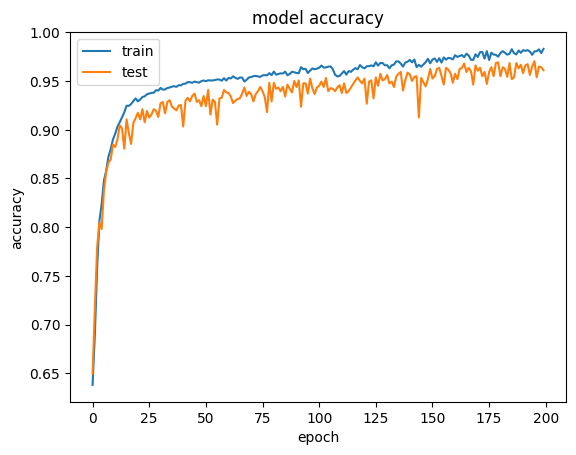

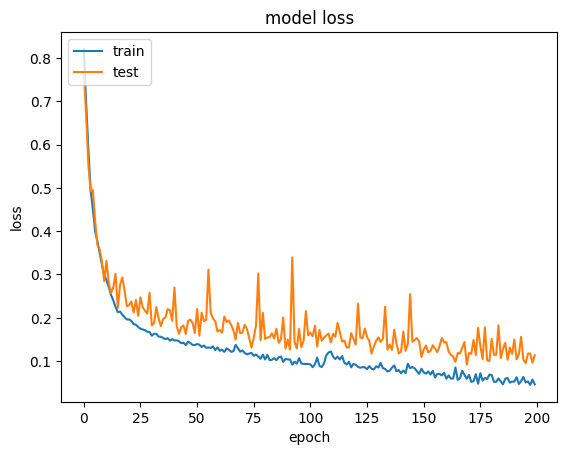

In [14]:
model.save_weights("new_data_train_4_10.h5")
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acc.jpg')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.jpg')
plt.show()

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import Sequence

# class MyDataGenerator(Sequence):
#     def __init__(self, X, y, batch_size=32):
#         self.X = X
#         self.y = y
#         self.batch_size = batch_size
        
#     def __len__(self):
#         return int(np.ceil(len(self.X) / float(self.batch_size)))
    
#     def __getitem__(self, idx):
#         batch_X = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_X, batch_y

# # 创建数据增强器对象
# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False)

# from sklearn.model_selection import train_test_split    
# # X_train, X_val, y_train, y_val = train_test_split(all_slices, all_index, test_size=0.1, random_state=42)
# batch_size=32
# # 生成训练数据迭代器
# train_generator = datagen.flow(all_slices, all_index, batch_size=batch_size)

# # 生成验证数据迭代器
# # val_generator = MyDataGenerator(X_val, y_val, batch_size=batch_size)

# # 训练模型
# model.fit(train_generator, 
#           steps_per_epoch=len(X_train) // batch_size, 
#           epochs=500, 
#           validation_data=val_generator,
#           validation_steps=len(X_val) // batch_size)


In [ ]:
#训练
# from tensorflow.keras import optimizers
# # 训练模型
# history = model.fit(
#         x_generator,
#         steps_per_epoch=len(X_train)//batch_size,
#         epochs=500,
#         validation_data=y_generator,
#         validation_steps=100,
#         callbacks=[validation_callback])
import os 
import scipy
# print(scipy._file_)
os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:2'
# history=model.fit(x_generator, epochs=500, steps_per_epoch=len(all_slices)//batch_size
# )
history = model.fit(all_slices,all_index,epochs=500,batch_size=6,validation_split=0.1,verbose=1)

# # history = model.fit(all_slices,
# all_index,
# batch_size=16,
# epochs=100,
# shuffle=True,
# validation_split= 0.1,
# #verbose=2,
# #       validation_data = ([x_train], [y_train])
# )

#1114/1115 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.90272022-12-22 00:54:14.426627: 
#1114/1115 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.1112023-01-12 19:39:39.627
model.save_weights("../home/user/new_data_train_512&256.h5")
# # import torch
#重点是tf=2.7，其他的就没问题了
#conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.6 -c pytorch -c conda-forge
#pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu116
#conda install -c conda-forge tensorflow=2.7 最好的安装代码
time_in = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
print("jieshu",time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))



                                                       在训练，别关就行，可以另外再开一个界面 


Epoch 1/500
2436/2436 [==============================] - 531s 216ms/step - loss: 0.4365 - accuracy: 0.7197 - val_loss: 1.2436 - val_accuracy: 0.0000e+00
Epoch 2/500
2436/2436 [==============================] - 519s 213ms/step - loss: 0.3831 - accuracy: 0.7542 - val_loss: 1.1375 - val_accuracy: 0.0000e+00
Epoch 3/500
2436/2436 [==============================] - 519s 213ms/step - loss: 0.3678 - accuracy: 0.7637 - val_loss: 1.2613 - val_accuracy: 0.0055
Epoch 4/500
2436/2436 [==============================] - 519s 213ms/step - loss: 0.3548 - accuracy: 0.7777 - val_loss: 1.3624 - val_accuracy: 0.0289
Epoch 5/500
2436/2436 [==============================] - 518s 213ms/step - loss: 0.3408 - accuracy: 0.7835 - val_loss: 0.9810 - val_accuracy: 0.0616
Epoch 6/500
2436/2436 [==============================] - 518s 213ms/step - loss: 0.3289 - accuracy: 0.7950 - val_loss: 1.3827 - val_accuracy: 0.0320
Epoch 7/500
2436/2436 [==============================] - 519s 213ms/step - loss: 0.3182 - accuracy

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = '../home/user/new_data_train_512&256.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

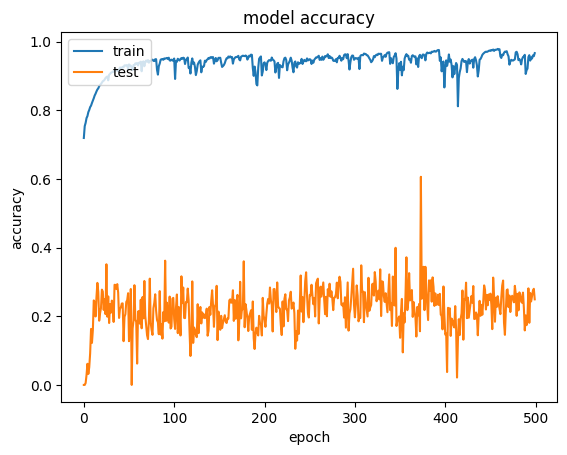

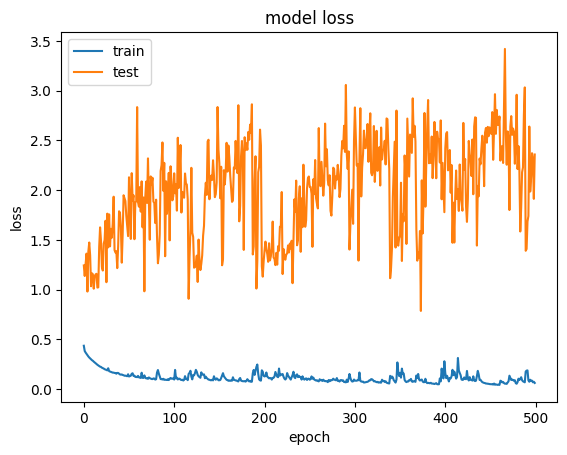

In [ ]:
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('for old people,s acc.jpg')
    plt.show() 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('for old people,s loss.jpg')
    plt.show()

In [ ]:
# from keras.callbacks import LearningRateScheduler
 
# def scheduler_cosine_decay(epoch,learning_rate=0.01, decay_steps=250, alpha=0.0001):
#     if epoch==0:
#       global global_step
#       global new_lr
#       global sess
#       global_step = tf.Variable(tf.constant(0))  
#       new_lr = tf.train.cosine_decay(learning_rate,global_step, decay_steps, alpha)
#       sess = tf.Session() 
#     lr = sess.run(new_lr,feed_dict={global_step: epoch})
#     return lr
 
# reduce_lr = LearningRateScheduler(scheduler_cosine_decay)

# datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False)

# # from sklearn.model_selection import train_test_split    
# # X_train, X_val, y_train, y_val = train_test_split(all_slices, all_index, test_size=0.1, random_state=42)
# batch_size=8
# # 生成训练数据迭代器
# train_generator = datagen.flow(all_slices, all_index, batch_size=batch_size)

#下面时换了一下损失函数，并且智跑300个epoch
adam = optimizers.adam_v2.Adam(lr=1e-4)
model.compile(loss = {'outputs':"categorical_crossentropy"},
        optimizer=adam, metrics=['accuracy'])
# history = model.fit(train_generator,epochs=100)

history = model.fit(all_slices,
all_index,
batch_size=16,
epochs=100,
shuffle=True,
validation_split= 0.1,
verbose=1
)
                                                                
                                                                
                                                              #  在跑代码,别关，最小化就行

Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/capsule_1/einsum_2/Einsum_1' defined at (most recent call last):
    File "d:\Anaconda\envs\lswsw\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\Anaconda\envs\lswsw\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "d:\Anaconda\envs\lswsw\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "d:\Anaconda\envs\lswsw\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "d:\Anaconda\envs\lswsw\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_16360\2668254235.py", line 34, in <module>
      history = model.fit(train_generator,epochs=100)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\engine\training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "d:\Anaconda\envs\lswsw\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/capsule_1/einsum_2/Einsum_1'
OOM when allocating tensor with shape[16,64,32,31752] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/capsule_1/einsum_2/Einsum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12787]